https://drive.google.com/file/d/1y0r1ES3krzQ5wf1ezLdRj7Vcn7JG4UlF/view?usp=sharing


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# drive.flush_and_unmount()

#yolov8 훈련하기 시작

dataset을 저장할 폴더를 만들고 그곳으로 들어갑니다

In [ ]:
%mkdir datas

In [39]:
# !cp /content/drive/MyDrive/Colab_Notebooks/KAIROS/Cobot_Yolo/my_data.zip /content/
# !cp /content/drive/MyDrive/Colab_Notebooks/KAIROS/Yolo/screw_hole_data.zip /content/
# !cp /content/drive/MyDrive/My_Colab_Notebooks/Doosan/my_data.zip /content/
!cp /content/drive/MyDrive/My_Colab_Notebooks/Doosan/amr_data.zip /content/

In [40]:
!unzip /content/amr_data.zip -d datas/
# !unzip /content/my_data.zip -d dataset/
# !unzip /content/screw_hole_data.zip -d dataset/

Archive:  /content/amr_data.zip
   creating: datas/amr_data/
   creating: datas/amr_data/train/
   creating: datas/amr_data/train/images/
  inflating: datas/amr_data/train/images/turtleview_img_36.jpg  
  inflating: datas/amr_data/train/images/car_img_59.jpg  
  inflating: datas/amr_data/train/images/turtleview_img_72.jpg  
  inflating: datas/amr_data/train/images/turtleview_img_10.jpg  
  inflating: datas/amr_data/train/images/car_img_72.jpg  
  inflating: datas/amr_data/train/images/turtleview_img_74.jpg  
  inflating: datas/amr_data/train/images/car_img_81.jpg  
  inflating: datas/amr_data/train/images/turtleview_img_11.jpg  
  inflating: datas/amr_data/train/images/turtleview_img_22.jpg  
  inflating: datas/amr_data/train/images/turtleview1_img_3.jpg  
  inflating: datas/amr_data/train/images/car_img_15.jpg  
  inflating: datas/amr_data/train/images/turtleview_img_27.jpg  
  inflating: datas/amr_data/train/images/car_img_43.jpg  
  inflating: datas/amr_data/train/images/turtleview1

In [ ]:
#%cd dataset

(480, 640, 3)


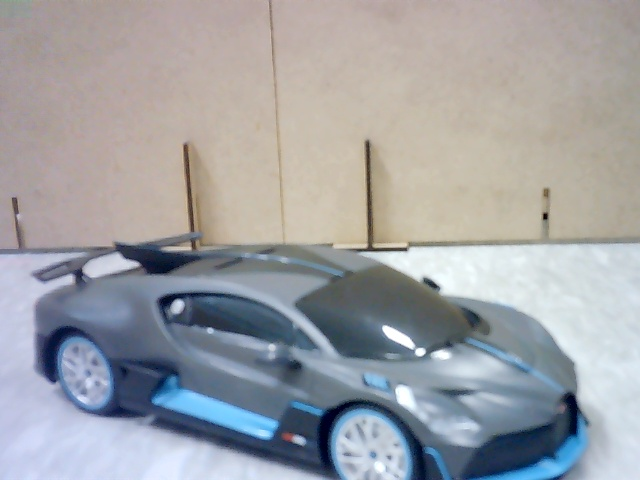

In [42]:
# Check if image all loarded ok
import glob
import cv2
from google.colab.patches import cv2_imshow
import random


# 이미지 파일 경로를 가져오기
# image_paths = glob.glob('/content/drive/MyDrive/team/test/images/*.jpg')
# image_paths = glob.glob('/content/dataset/team/test/images/*.png')
# image_paths = glob.glob('/content/dataset/my_data/test/*.jpg')
image_paths = glob.glob('/content/datas/amr_data/test/images/*.jpg')

# 이미지가 없는 경우 에러 처리
if not image_paths:
    print("이미지 파일이 없습니다.")
else:
    # 랜덤하게 이미지 선택
    selected_image_path = random.choice(image_paths)

    # 이미지 표시
    img = cv2.imread(selected_image_path)
    print(img.shape)
    cv2_imshow(img)

해당경로에 이미지와 data.yaml이 나온것을 확인 할 수 있습니다

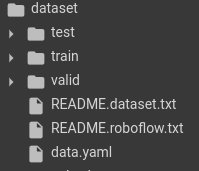

data.yaml을 확인합니다

In [43]:
%cat data.yaml

cat: data.yaml: No such file or directory


새로운 yaml파일을 만들고 train, val, test 데이터셋 경로가 올바른게 작성해줘야 합니다



```
변경전                       변경후
train: ../train/images  ->  'train' : '/content/dataset/train/images'
```



In [44]:
import yaml

data = {
        'train' : '/content/datas/amr_data/train/images',
        'test' : '/content/datas/amr_data/test/images',
        'val' : '/content/datas/amr_data/valid/images',
        # 'train' : '/content/dataset/train/images',
        # 'test' : '/content/dataset/test/images',modules/highgui/src/window.cpp:1284: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu
        # 'val' : '/content/dataset/valid/images',

        'nc': 5,
        'names': ['dummy1','dummy2','turtlebot',' ','car']
        # 'names': ['Truck','Dummy']
        # 'names': ['Normal','Error']
        # 'names' : ['NG', 'OK']
}

# with open('/content/dataset/my_data/custom_data.yaml', 'w') as f:
with open('/content/datas/custom_data.yaml', 'w') as f:
  yaml.dump(data, f)

custom_data.yaml 파일을 만들었으니 제대로 작성이 되었는지 확인합니다

In [45]:
# with open('/content/dataset/my_data/custom_data.yaml', 'r') as f:
with open('/content/datas/custom_data.yaml', 'r') as f:
  view_yaml = yaml.safe_load(f)
  display(view_yaml)


{'names': ['dummy1', 'dummy2', 'turtlebot', ' ', 'car'],
 'nc': 5,
 'test': '/content/datas/amr_data/test/images',
 'train': '/content/datas/amr_data/train/images',
 'val': '/content/datas/amr_data/valid/images'}

yolov8을 인스톨합니다

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 43.2 MB/s eta 0:00:00


yolov8이 제대로 설치가 되었는지 확인합니다

In [ ]:
import ultralytics

ultralytics.checks()

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/112.6 GB disk)


사전에 학습된 yolov8n.pt를 가져오고 적용시킵니다

yolov8의 학습파일은 yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt 등이 있습니다

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 323MB/s]


yolov8에서 사용하는 model이 yolov8n.pt 인지 확인해봅니다

yolov8은 cocodata의 분류를 가져서 80개의 name이 저장되어있습니다

In [ ]:
print(type(model.names),len(model.names))#우리가 원하는 데이터셋 경로를 가진 custom_data.yaml을 가지고 학습을 시작합니다

print(model.names)

<class 'dict'> 80
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell p

우리가 원하는 데이터셋 경로를 가진 custom_data.yaml을 가지고 학습을 시작합니다

In [ ]:
results = model.predict('https://ultralytics.com/images/bus.jpg', save=True, show=True)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()




100%|██████████| 134k/134k [00:00<00:00, 39.2MB/s]


image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 41.4ms
Speed: 9.6ms preprocess, 41.4ms inference, 891.4ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict


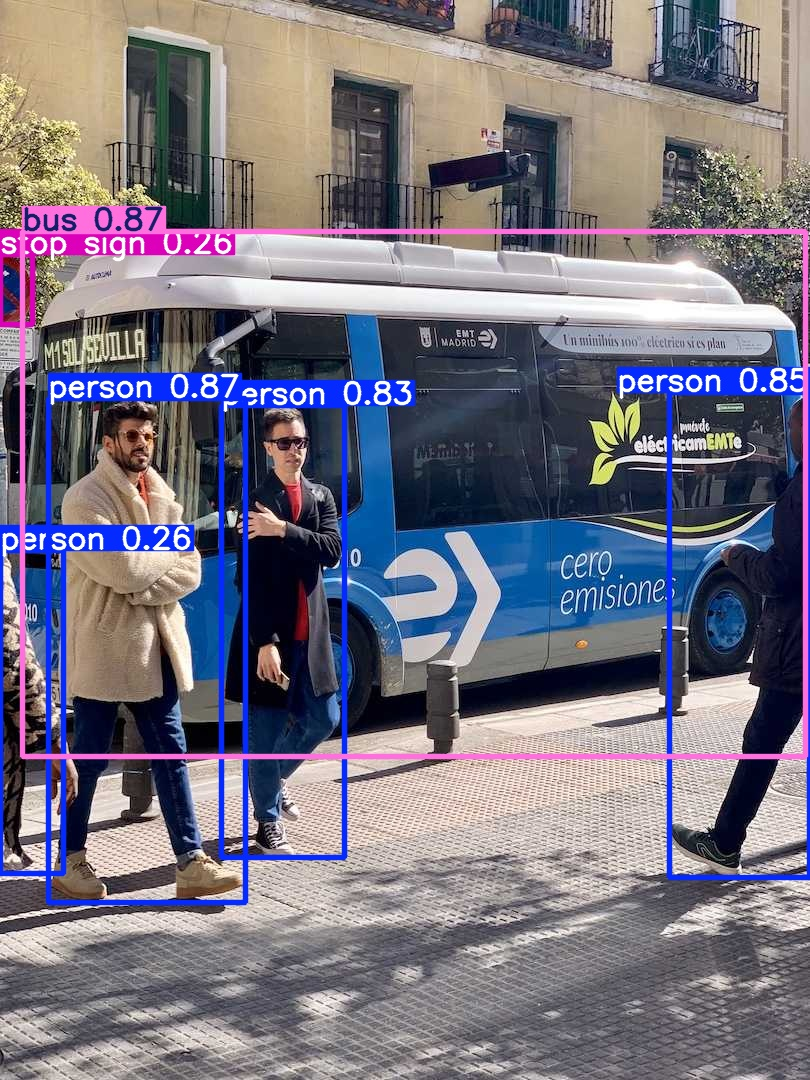

In [ ]:
from IPython.display import Image, clear_output
Image(filename='/content/runs/detect/predict/bus.jpg',width=1000)

In [46]:
model.train(
    data='/content/datas/custom_data.yaml',
    epochs=100,
    patience=20,
    batch=32,
    imgsz=640
)

#model.train(data='/content/dataset/custom_data.yamlmodules/highgui/src/window.cpp:1284: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu', epochs= 100, patience = 20, batch=32, imgsz =640)

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/datas/custom_data.yaml, epochs=100, time=None, patience=20, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /content/datas/amr_data/train/labels... 0 images, 161 backgrounds, 0 corrupt: 100%|██████████| 161/161 [00:00<00:00, 2877.39it/s]

train: WARNING ⚠️ No labels found in /content/datas/amr_data/train/labels.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
train: New cache created: /content/datas/amr_data/train/labels.cache
WARNING ⚠️ No labels found in /content/datas/amr_data/train/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datas/amr_data/valid/labels... 0 images, 46 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 845.81it/s]

val: WARNING ⚠️ No labels found in /content/datas/amr_data/valid/labels.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
val: New cache created: /content/datas/amr_data/valid/labels.cache
WARNING ⚠️ No labels found in /content/datas/amr_data/valid/labels.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


Plotting labels to runs/detect/train2/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.43G          0      295.1          0          0        640: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         46          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.87G          0      281.3          0          0        640: 100%|██████████| 6/6 [00:01<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         46          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.87G          0      251.7          0          0        640: 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         46          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.87G          0      93.32          0          0        640: 100%|██████████| 6/6 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         46          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


KeyboardInterrupt: 

학습한 결과 분석은 다음경로에 새롭게 저장되었습니다

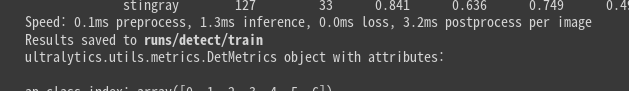

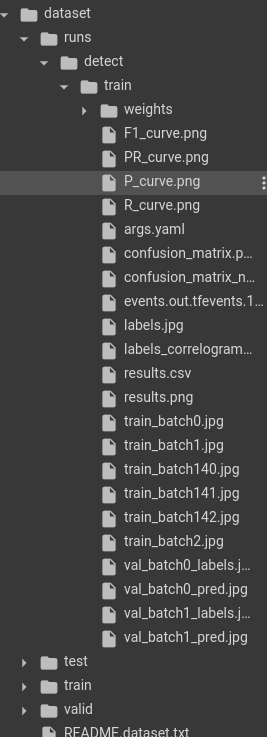

학습한 모델은 weights/best.pt 로 저장되어있습니다

yolov8은 학습하고 나서 자동적으로 모델을 변경합니다

실제로 변경되는지 확인합니다

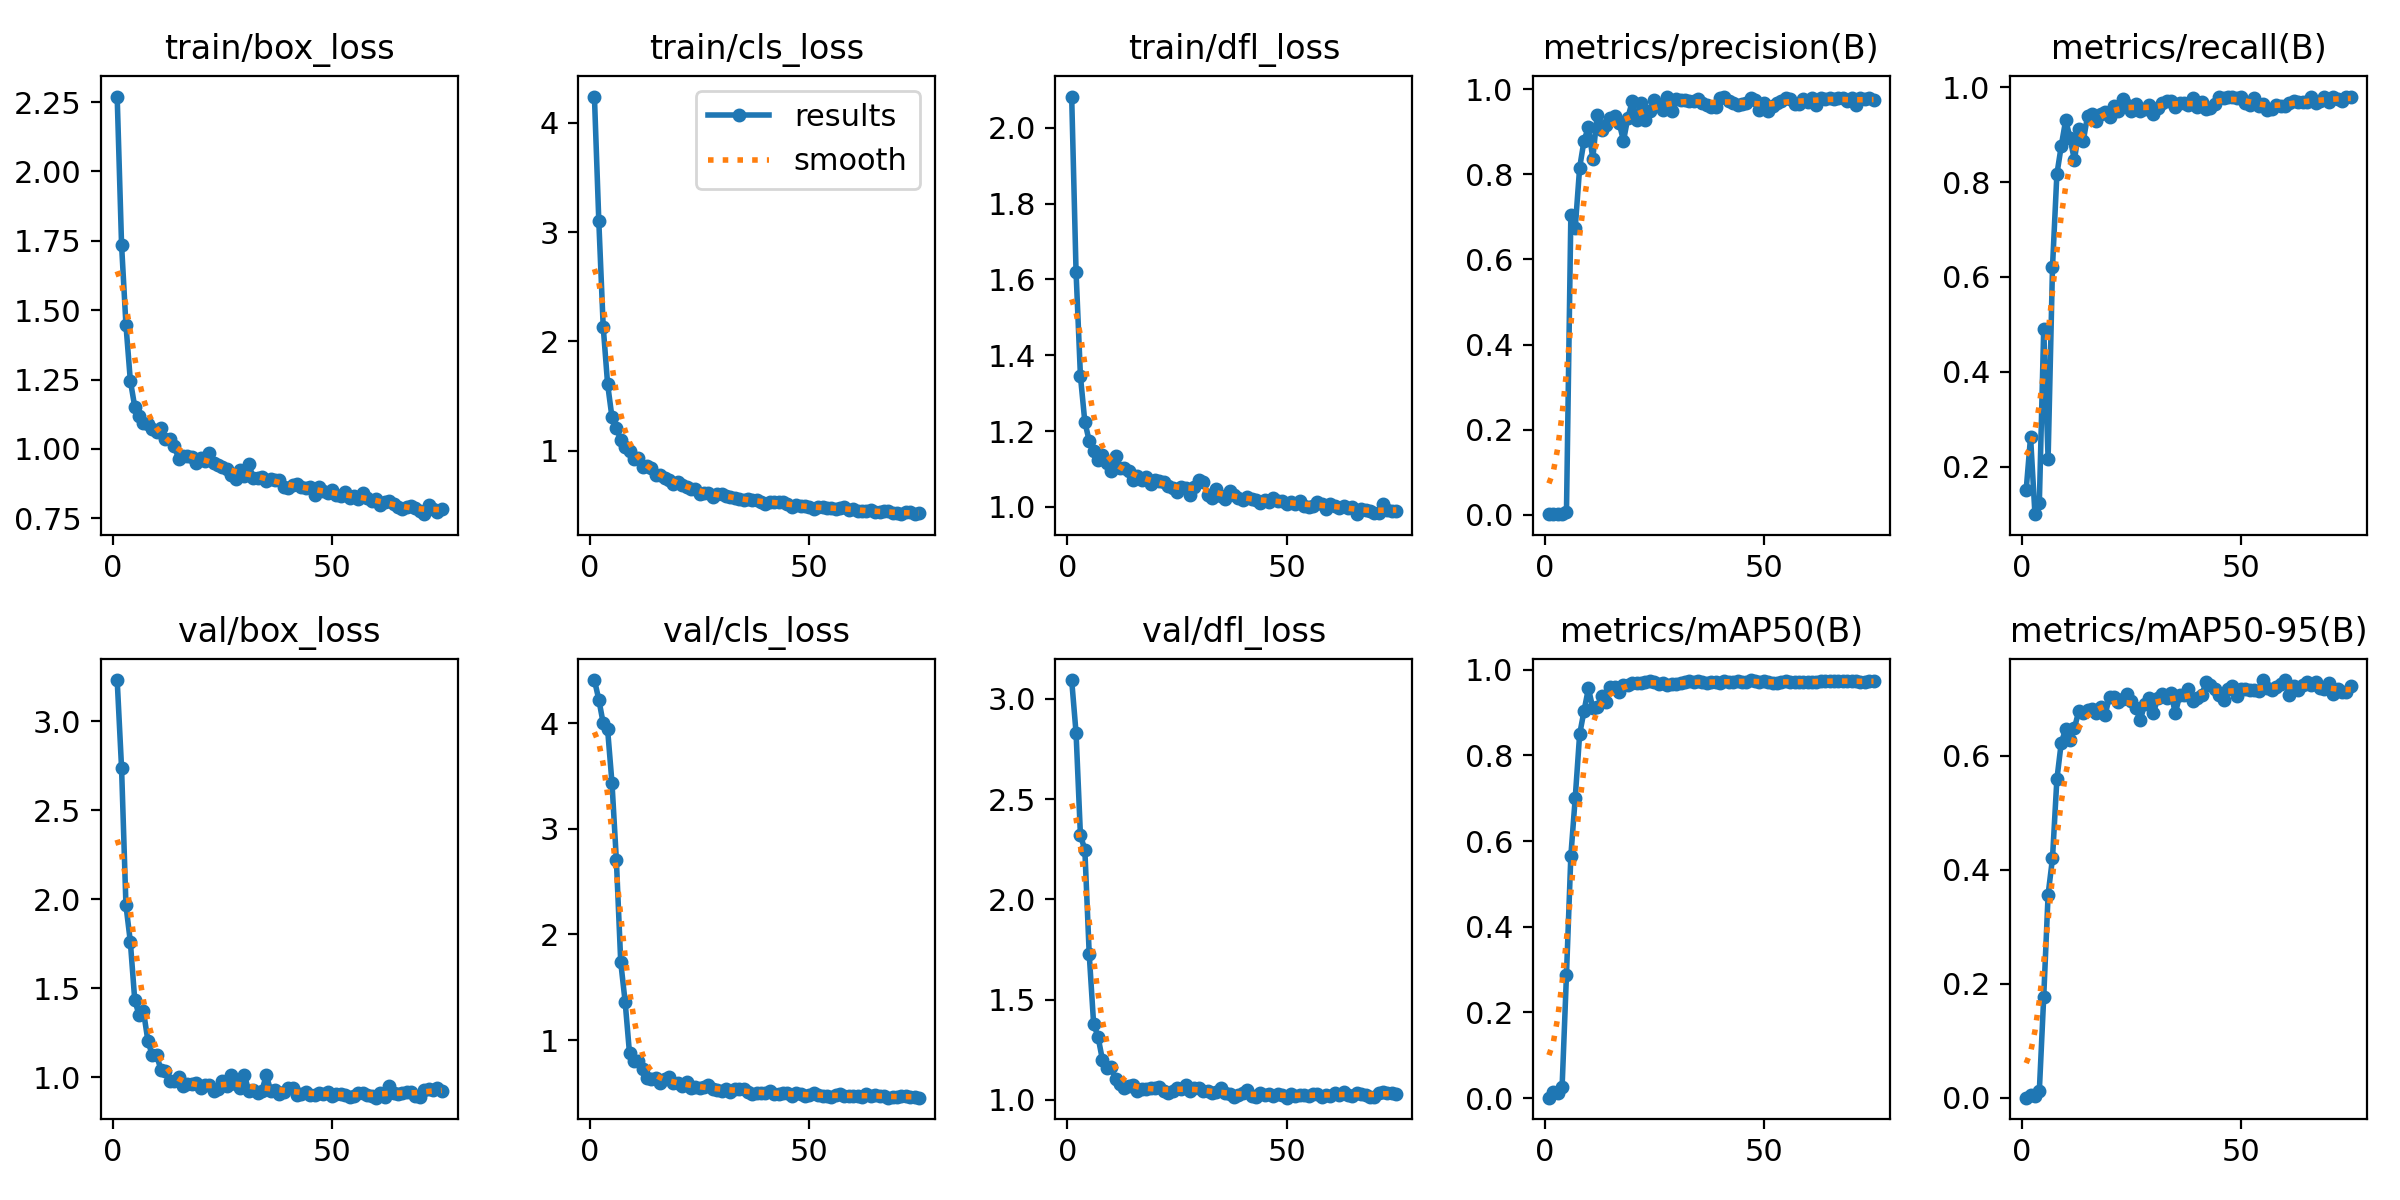

In [ ]:
from IPython.display import Image, clear_output
Image(filename='/content/runs/detect/train/results.png',width=1000)

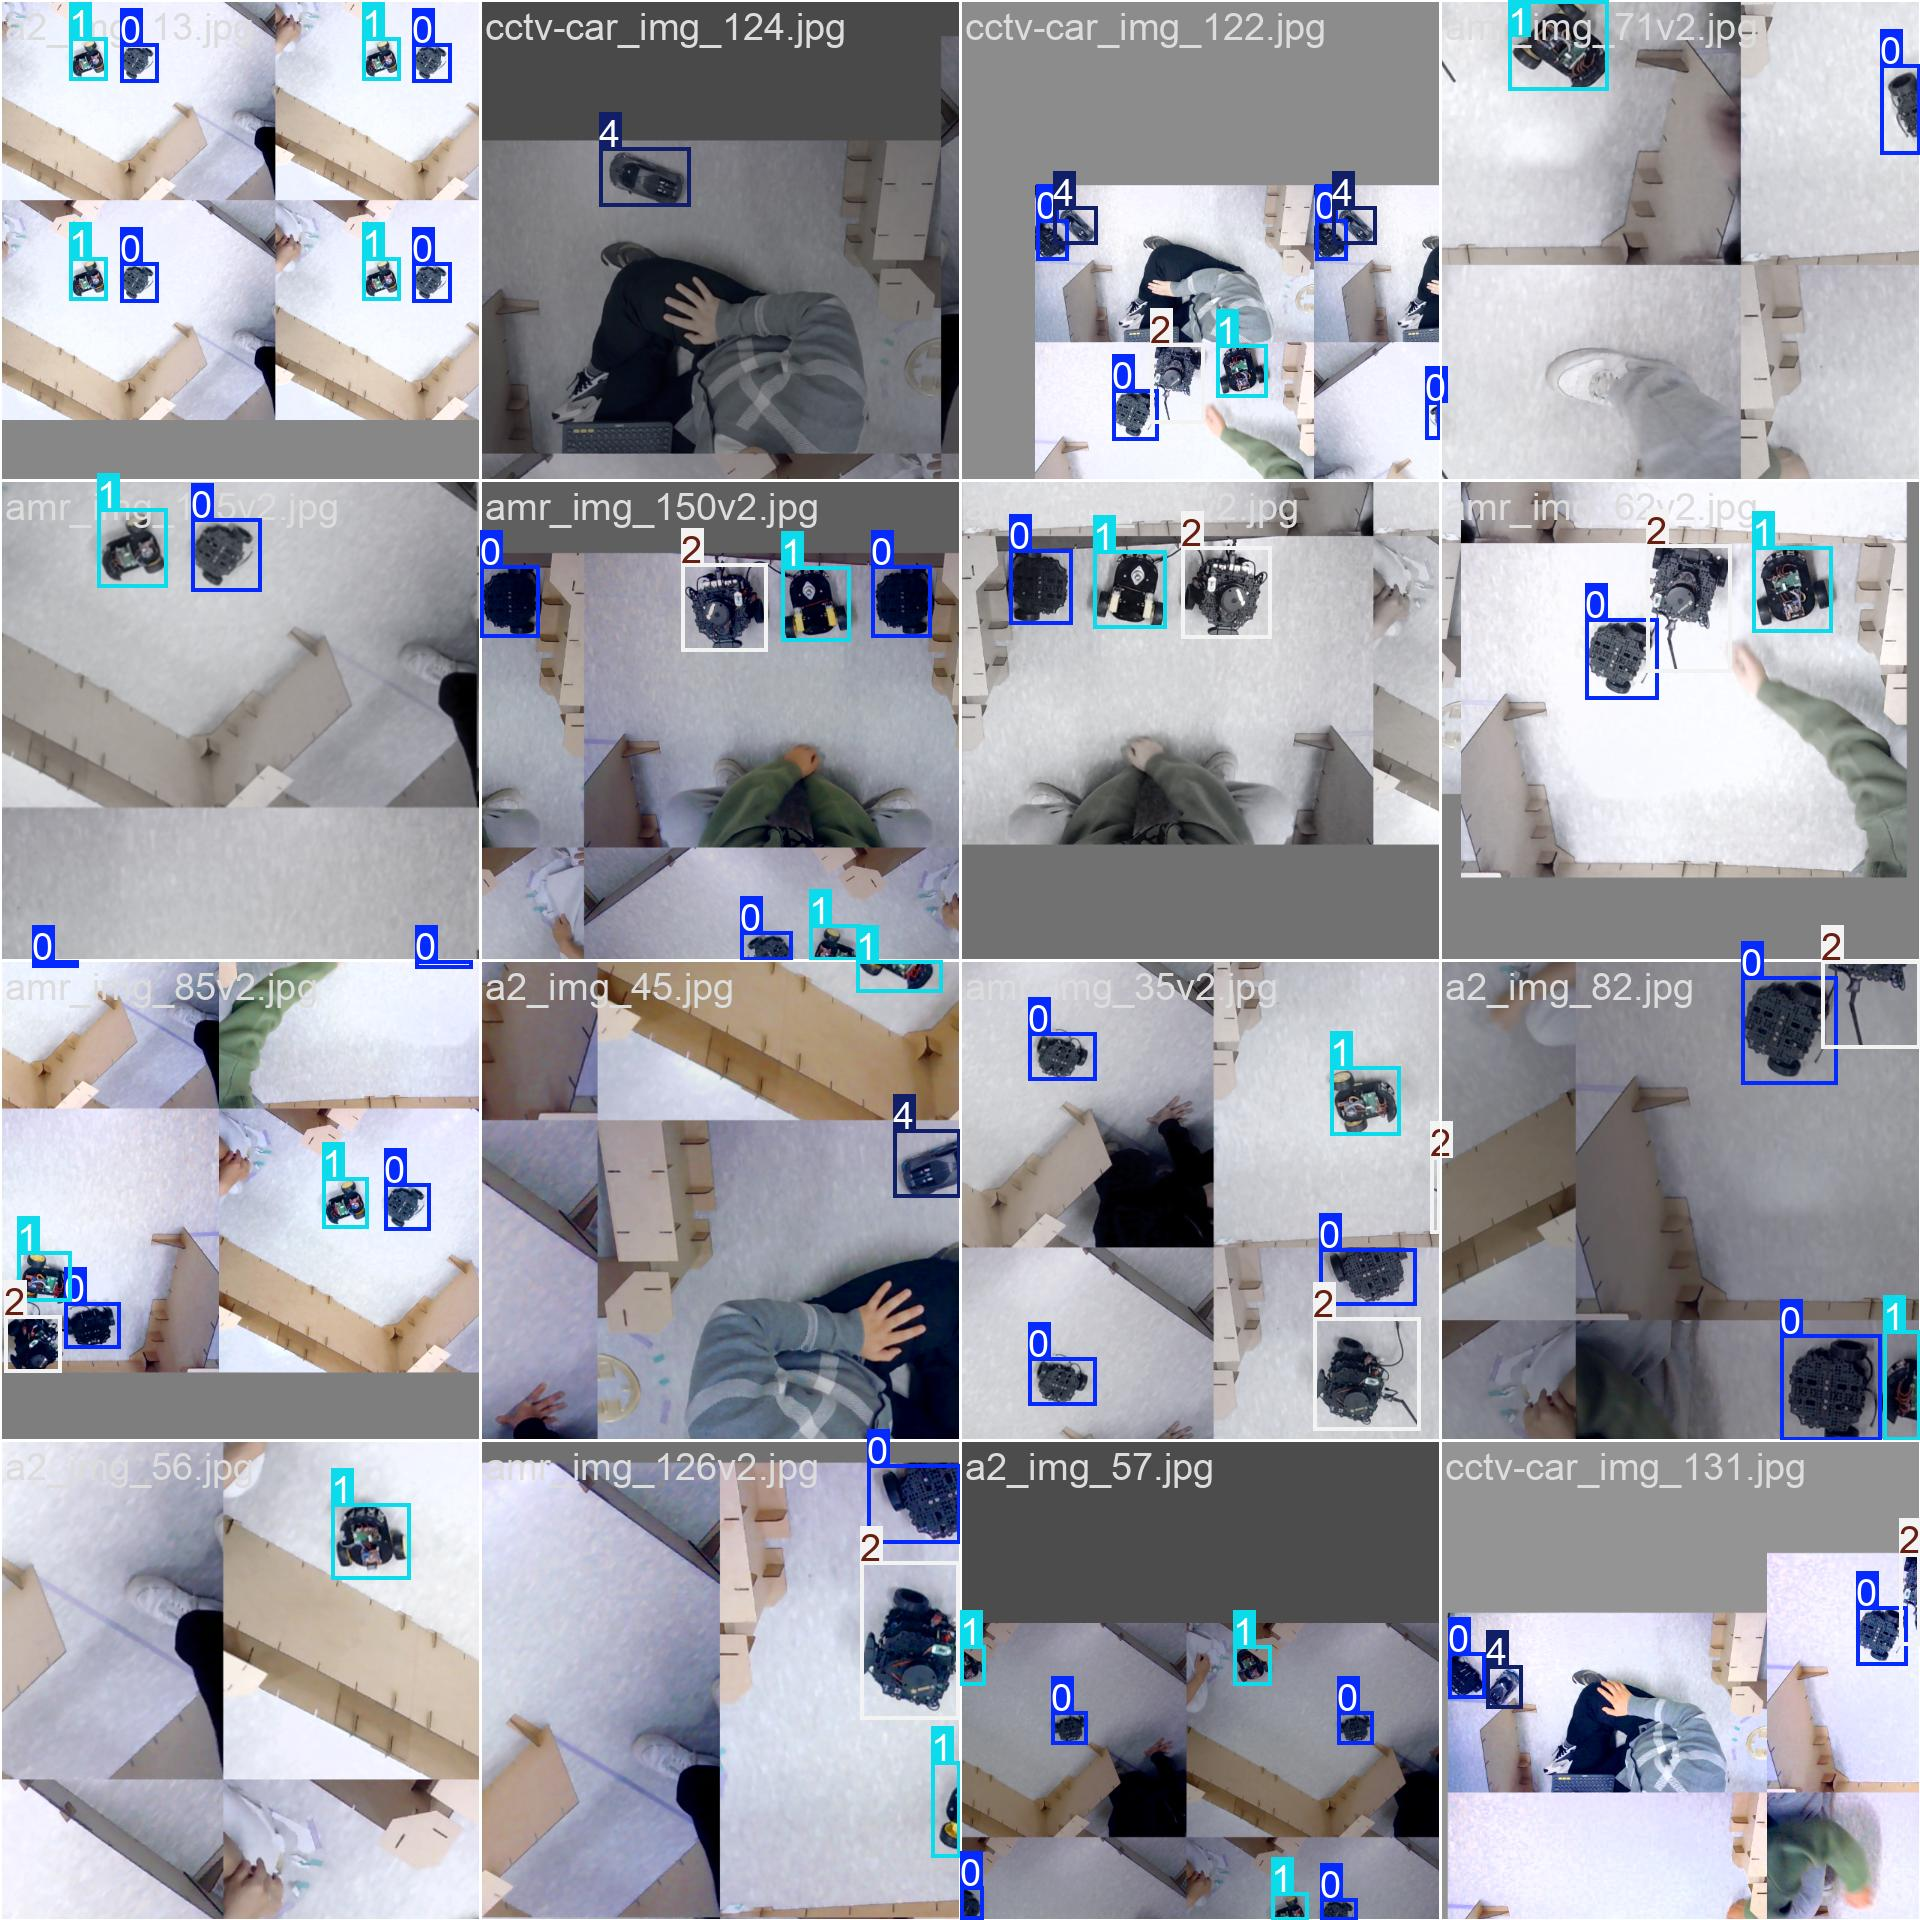

In [ ]:
Image(filename='/content/runs/detect/train/train_batch0.jpg',width=1000)
# Image(filename='/content/runs/detect/train5/train_batch0.jpg',width=1000)

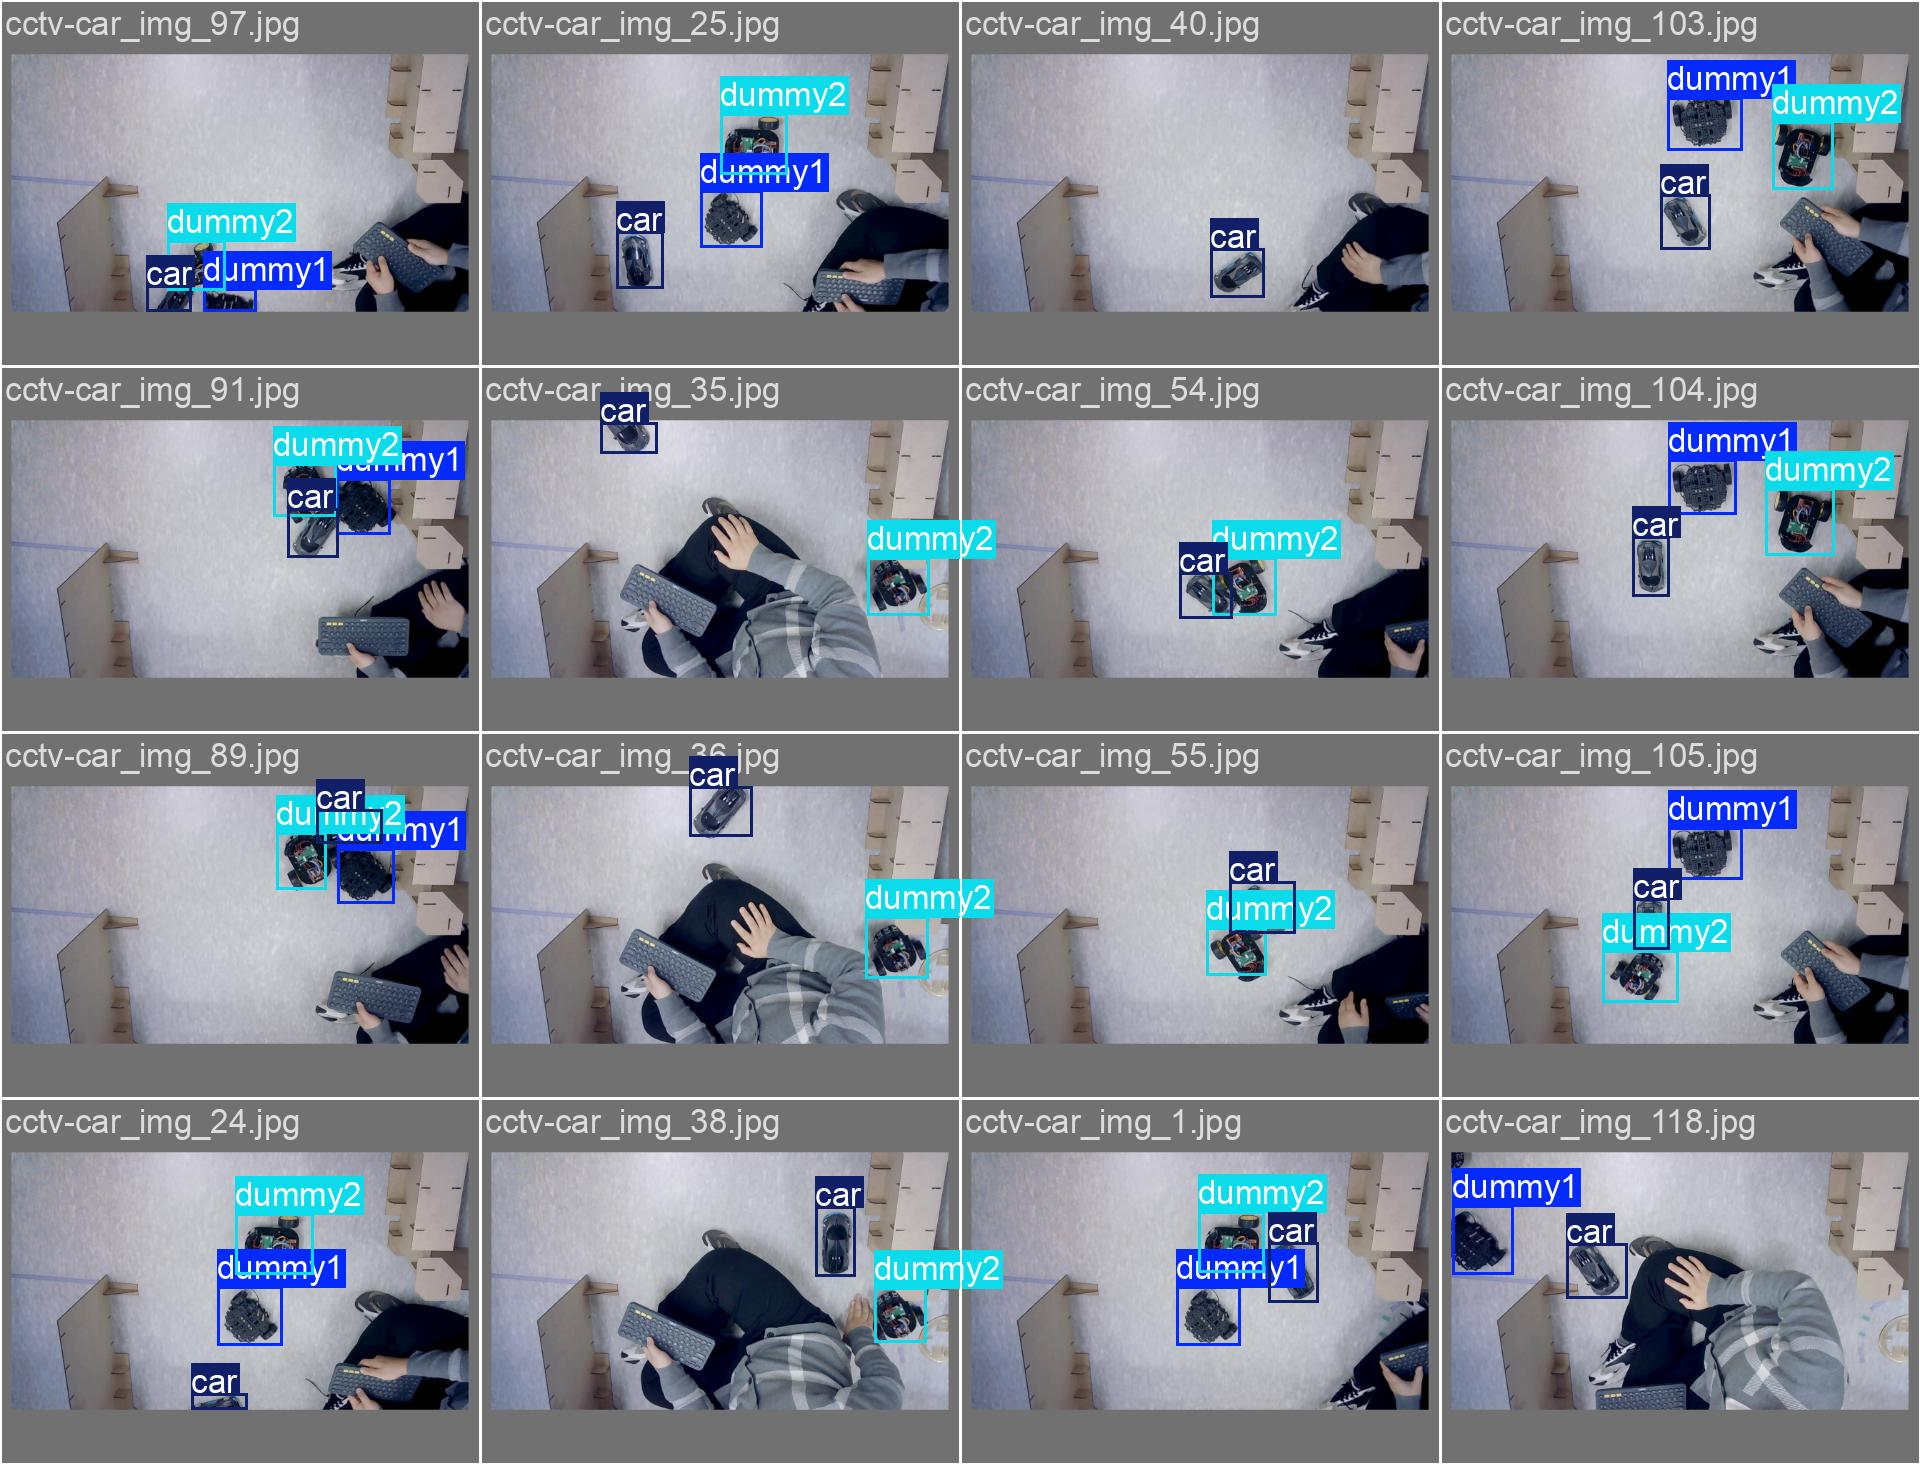

In [ ]:
Image(filename='/content/runs/detect/train/val_batch0_labels.jpg',width=1000)


In [ ]:
print(type(model.names),len(model.names))

print(model.names)

<class 'dict'> 5
{0: 'dummy1', 1: 'dummy2', 2: 'turtlebot', 3: ' ', 4: 'car'}


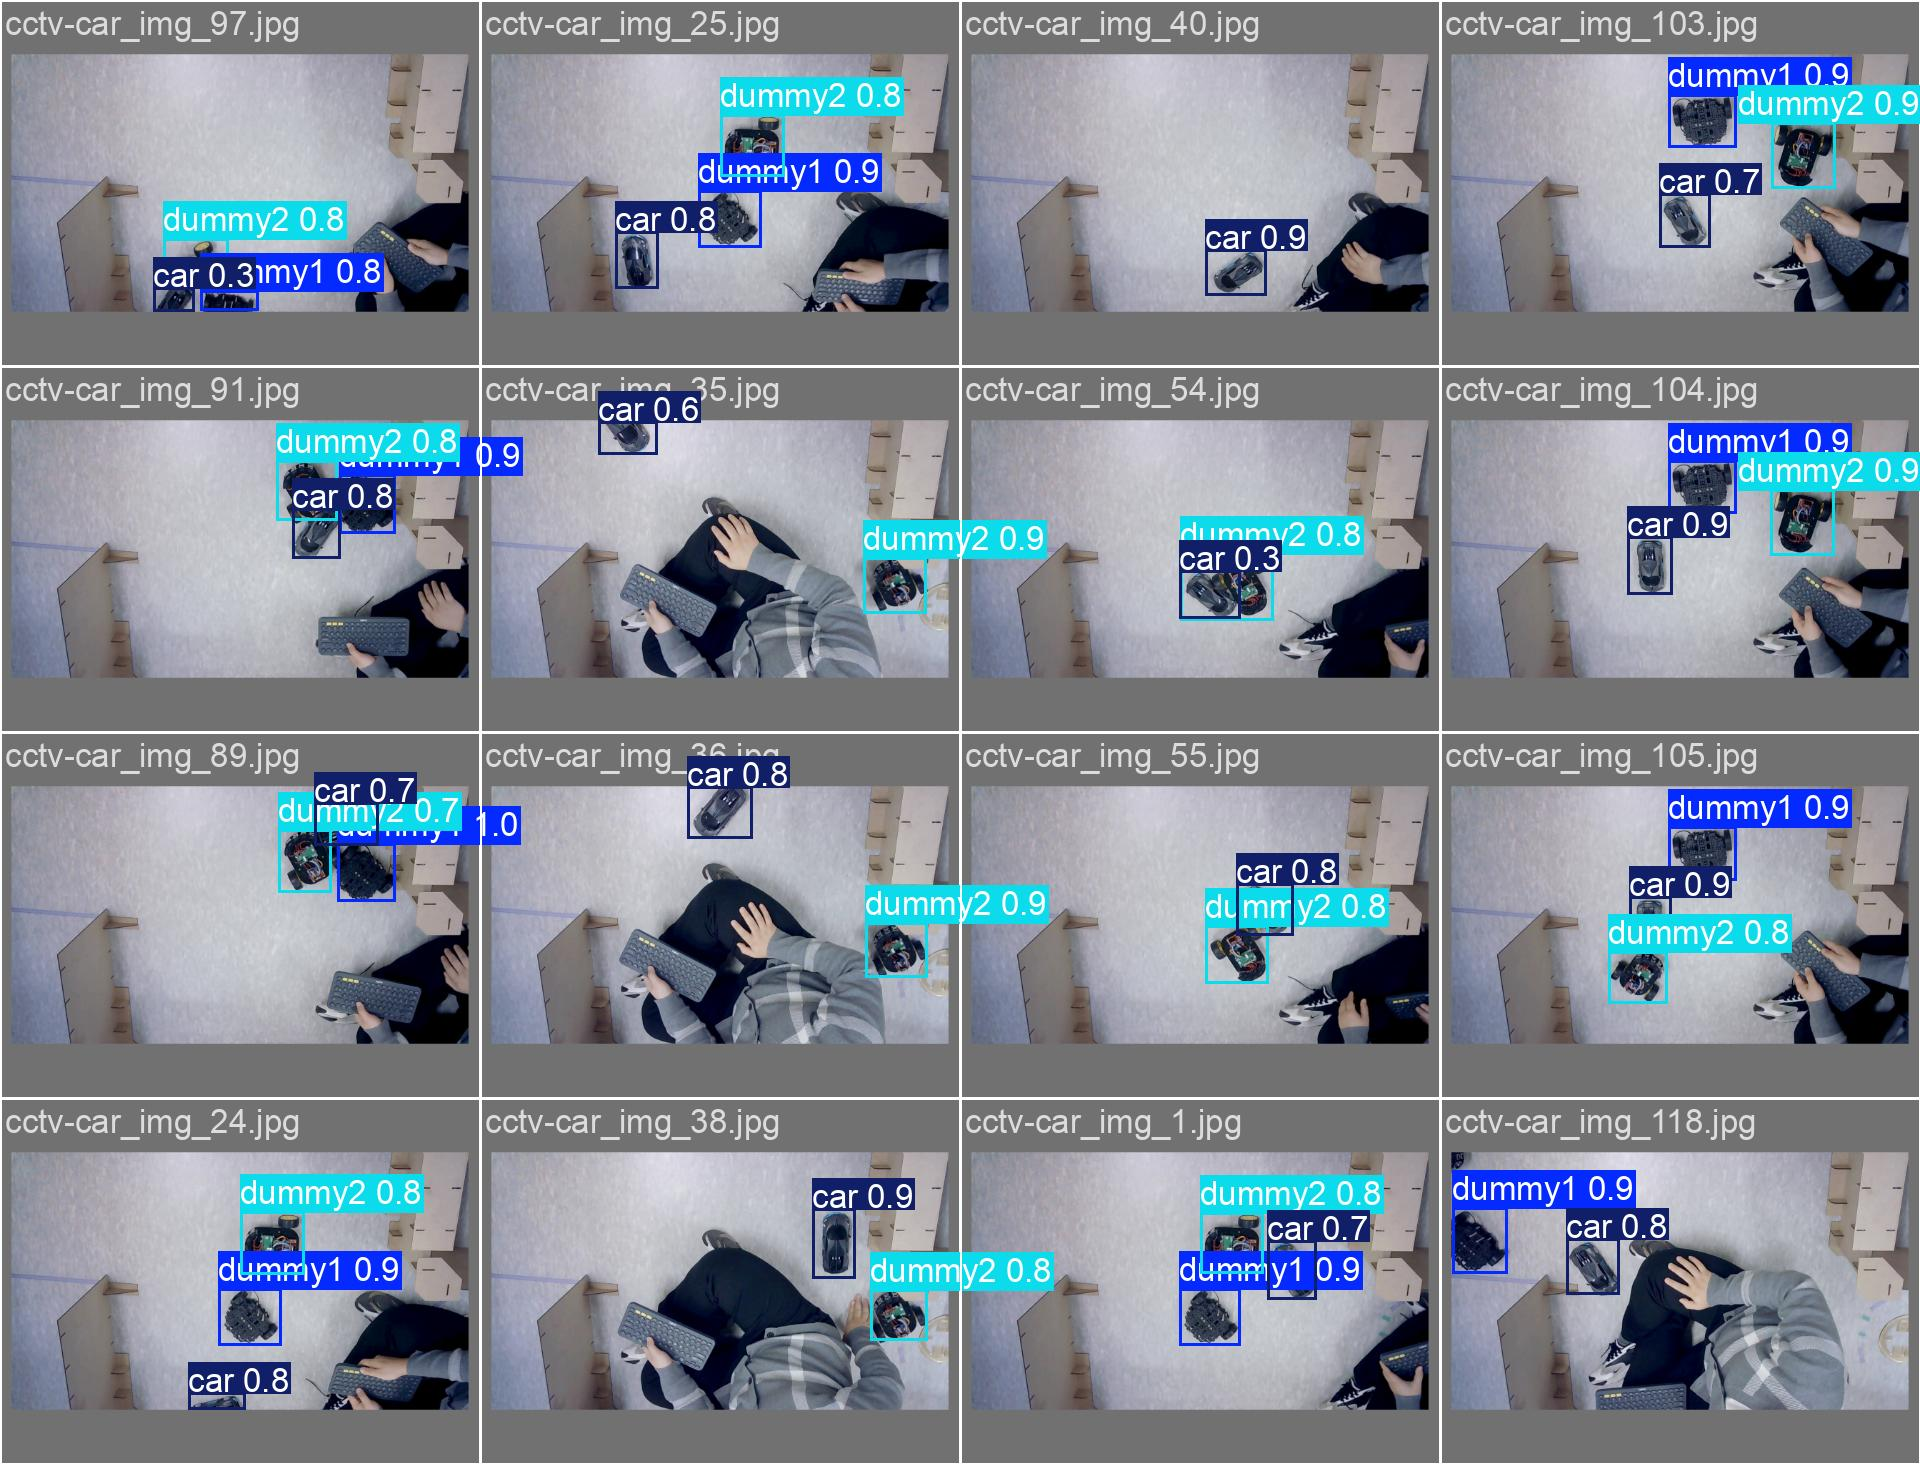

In [ ]:
Image(filename='/content/runs/detect/train/val_batch0_pred.jpg',width=1000)

학습된 결과물을 출력하는 부분입니다

마지막 출력문인 'Results saved to '이후에 나오는 경로가 학습된 이미지 출력이 있는 폴더의 경로입니다

image.png

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')

In [ ]:
print(type(model.names),len(model.names))

print(model.names)

<class 'dict'> 5
{0: 'dummy1', 1: 'dummy2', 2: 'turtlebot', 3: ' ', 4: 'car'}


In [ ]:
# 테스트 이미지

from glob import glob

test_image_list = glob('/content/data/test/images/*')

print(len(test_image_list))

test_image_list.sort()

for i in range(len(test_image_list)):

    print('i = ',i, test_image_list[i])

0


In [ ]:
# results = model.predict(source ='/content/dataset/my_data/test/images/', save=True)
results = model.predict(source ='/content/data/cctv_data/test/images', save=True)


image 1/45 /content/data/cctv_data/test/images/a2_img_19.jpg: 480x640 1 dummy1, 1 dummy2, 38.7ms
image 2/45 /content/data/cctv_data/test/images/a2_img_2.jpg: 480x640 1 dummy1, 1 dummy2, 6.4ms
image 3/45 /content/data/cctv_data/test/images/a2_img_27.jpg: 480x640 1 dummy1, 1 dummy2, 6.9ms
image 4/45 /content/data/cctv_data/test/images/a2_img_28.jpg: 480x640 1 dummy1, 1 dummy2, 11.2ms
image 5/45 /content/data/cctv_data/test/images/a2_img_3.jpg: 480x640 1 dummy1, 1 dummy2, 6.5ms
image 6/45 /content/data/cctv_data/test/images/a2_img_38.jpg: 480x640 1 dummy1, 1 dummy2, 7.3ms
image 7/45 /content/data/cctv_data/test/images/a2_img_39.jpg: 480x640 1 dummy1, 1 dummy2, 6.1ms
image 8/45 /content/data/cctv_data/test/images/a2_img_4.jpg: 480x640 1 dummy1, 1 dummy2, 6.4ms
image 9/45 /content/data/cctv_data/test/images/a2_img_46.jpg: 480x640 1 dummy1, 1 dummy2, 6.5ms
image 10/45 /content/data/cctv_data/test/images/a2_img_60.jpg: 480x640 1 dummy1, 1 dummy2, 6.8ms
image 11/45 /content/data/cctv_data/tes

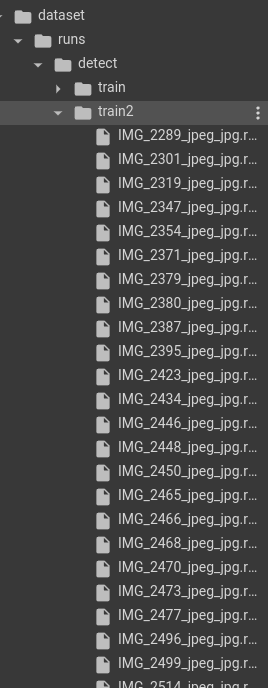

해당 경로에서 랜덤으로 이미지 출력을 보는 코드입니다

colab은 특수한 패키지를 사용해야 볼 수 있습니다

In [ ]:
# 이미지 파일 경로를 가져오기
# image_paths = glob('/content/runs/detect/predict2/*.jpg')
image_paths = glob('/content/runs/detect/predict4/*.jpg')

# 이미지가 없는 경우 에러 처리
if not image_paths:
    print("이미지 파일이 없습니다.")
else:
    # 랜덤하게 이미지 선택
    # selected_image_path = random.choice(image_paths)
    # 이미지 표시
    # img = cv2.imread(selected_image_path)

    for image_path in image_paths:
      img = cv2.imread(image_path)
      cv2_imshow(img)

이미지 파일이 없습니다.


만약 실제로 학습한 데이터를 자신의 드라이브에 저장하고 싶다면

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!cp /content/runs/detect/train/weights/best.pt /content/drive/MyDrive/My_Colab_Notebooks/Doosan
#cp /content/runs/detect/train/weights/best.pt /content/drive/MyDrive/My_Colab_Notebooks/Doosan/amr_best.pt
